In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

import mediapipe as mp
import cv2

import joblib

/tmp/ipykernel_15296/3015821433.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
main_directory = './dataset/asl_alphabet_train/asl_alphabet_train/'

In [3]:
class_dirs = [class_dir for class_dir in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, class_dir))]
class_dirs = sorted(class_dirs)
print(class_dirs)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [16]:
angle_range = 10
num_images_per_folder = 500

for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    
    if os.path.isdir(folder_path):
        total_images = min(len(os.listdir(folder_path)), num_images_per_folder)
        current_image = 0
        
        for image_name in os.listdir(folder_path):
            if current_image >= num_images_per_folder:
                break
            
            image_path = os.path.join(folder_path, image_name)
            
            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                
                for i in range(num_images_per_folder):
                    if current_image >= num_images_per_folder:
                        break
                    
                    angle = np.random.uniform(-angle_range, angle_range)
                    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
                    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
                    new_image_name = f"rotated_{i}_{image_name}"
                    new_image_path = os.path.join(folder_path, new_image_name)
                    cv2.imwrite(new_image_path, rotated_image)
                    
                    current_image += 1
                    percentage = (current_image / total_images) * 100
                    print(f"Progress: {percentage:.2f}% complete", end='\r')

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.5)

E0000 00:00:1707163505.029589    9226 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707163505.029721    9226 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707163505.029746    9226 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
keypoints_all = []

for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(main_directory, class_dir)
    for j, image_file in enumerate(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                keypoints = []
                for lm in hand_landmarks.landmark:
                    keypoints.append((lm.x, lm.y))
                if keypoints:
                    keypoints_all.append({
                        'label': class_dir,
                        'keypoints': keypoints
                    })

        total_images = len(class_dirs) * len(os.listdir(class_path))
        percentage = (i * len(os.listdir(class_path)) + j) / total_images * 100
        print(f"Progress: {percentage:.2f}% complete", end='\r')

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [6]:
df = pd.DataFrame(keypoints_all)

In [7]:
df.to_csv('./dataset/keypoints_xy.csv', index=False)

In [4]:
df = pd.read_csv('./keypoints_xy.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57769 entries, 0 to 57768
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      57769 non-null  object
 1   keypoints  57769 non-null  object
dtypes: object(2)
memory usage: 902.8+ KB


In [6]:
df.describe()

,label,keypoints
count,57769,57769
unique,25,57769
top,F,"[(0.577608585357666, 0.5037515759468079), (0.6..."
freq,2876,1


In [7]:
class_counts = df['label'].value_counts()

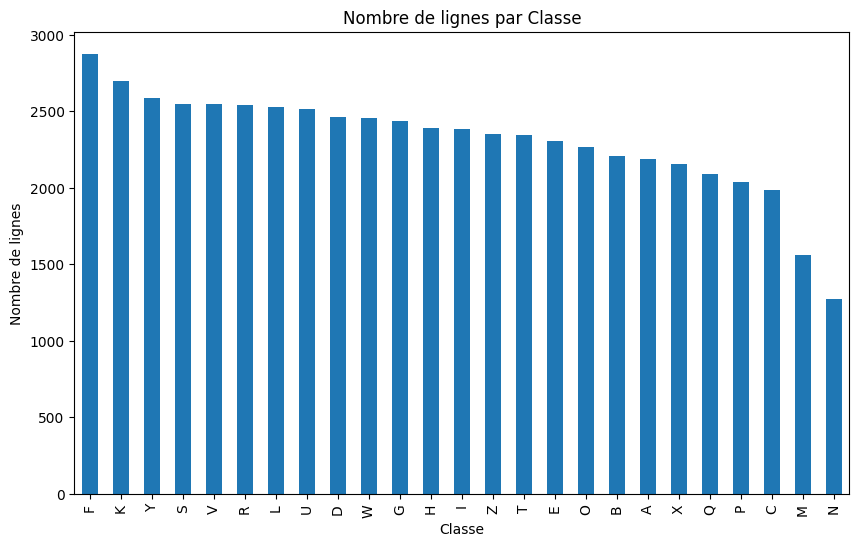

In [8]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre de lignes')
plt.title('Nombre de lignes par Classe')
plt.show()

In [9]:
seuil_bas = 1200
seuil_haut = 1500

classes_to_keep = class_counts[class_counts >= seuil_bas].index
df_filtered = pd.DataFrame(columns=df.columns)
for classe in classes_to_keep:
    df_classe = df[df['label'] == classe]
    if len(df_classe) > seuil_haut:
        df_classe = df_classe.head(seuil_haut)
    df_filtered = pd.concat([df_filtered, df_classe], ignore_index=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37276 entries, 0 to 37275
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      37276 non-null  object
 1   keypoints  37276 non-null  object
dtypes: object(2)
memory usage: 582.6+ KB


In [10]:
df_filtered.head(5)

,label,keypoints
0,F,"[(0.7516232132911682, 0.8792057633399963), (0...."
1,F,"[(0.7084242105484009, 1.0198203325271606), (0...."
2,F,"[(0.7344133853912354, 0.7317389845848083), (0...."
3,F,"[(0.5940902829170227, 0.8325281739234924), (0...."
4,F,"[(0.41573643684387207, 0.9189311265945435), (0..."


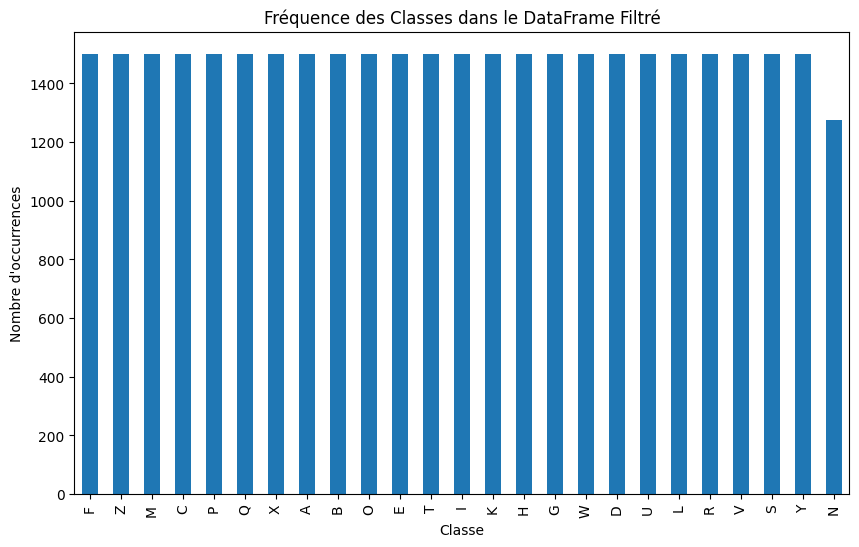

In [11]:
class_counts_filtered = df_filtered['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_filtered.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Fréquence des Classes dans le DataFrame Filtré')
plt.show()

In [12]:
class_counts_filtered.__len__()

25

In [13]:
def transform_tuples(row):
    keypoints = eval(row)
    return [coord for point in keypoints for coord in point]
df_filtered['keypoints'] = df_filtered['keypoints'].apply(transform_tuples)
print(df_filtered.head())
# df['keypoints'] = df['keypoints'].apply(transform_tuples)
# print(df.head())

  label                                          keypoints
0     F  [0.7516232132911682, 0.8792057633399963, 0.837...
1     F  [0.7084242105484009, 1.0198203325271606, 0.791...
2     F  [0.7344133853912354, 0.7317389845848083, 0.788...
3     F  [0.5940902829170227, 0.8325281739234924, 0.696...
4     F  [0.41573643684387207, 0.9189311265945435, 0.50...


In [14]:
X = pd.DataFrame(df_filtered['keypoints'].tolist())
y = df_filtered['label']

In [15]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.751623,0.879206,0.837763,0.854303,0.910334,0.805519,0.952996,0.745724,0.974737,0.683290,...,0.817870,0.476828,0.676901,0.660670,0.642354,0.588401,0.649532,0.545860,0.673128,0.519815
1,0.708424,1.019820,0.791864,0.942638,0.840449,0.830790,0.857077,0.721555,0.866267,0.622580,...,0.460499,0.424030,0.455104,0.825817,0.342781,0.767015,0.320175,0.698022,0.332256,0.627813
2,0.734413,0.731739,0.788834,0.712110,0.827558,0.659443,0.845928,0.603516,0.851253,0.555141,...,0.722917,0.453148,0.635359,0.608795,0.600047,0.563280,0.593494,0.527168,0.598558,0.499567
3,0.594090,0.832528,0.696812,0.717944,0.756647,0.605264,0.765380,0.494947,0.753807,0.395860,...,0.441722,0.215822,0.375280,0.575033,0.298143,0.496816,0.281519,0.431208,0.292852,0.367216
4,0.415736,0.918931,0.508268,0.838763,0.575753,0.729988,0.566639,0.630336,0.524902,0.557034,...,0.267766,0.362336,0.252540,0.691348,0.196186,0.613929,0.176809,0.561295,0.173003,0.510902


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier()
]

for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5) 
    print(f"Model: {type(model).__name__}")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

/home/mathieu/Dev/project/asl_web_app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mathieu/Dev/project/asl_web_app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model: LogisticRegression
Cross-validation scores: [0.95573441 0.9674715  0.95892019 0.95808182 0.96545942]
Mean score: 0.9611334674714955
Standard deviation: 0.0045220678285814945
Model: DecisionTreeClassifier
Cross-validation scores: [0.91230718 0.90794769 0.9139839  0.91314554 0.91281019]
Mean score: 0.9120389000670691
Standard deviation: 0.0021171957233621238
Model: RandomForestClassifier
Cross-validation scores: [0.97820255 0.97904091 0.97753186 0.9797116  0.9778672 ]
Mean score: 0.9784708249496982
Standard deviation: 0.0007978120223588557
Model: SVC
Cross-validation scores: [0.97199866 0.97635815 0.97199866 0.97300469 0.97619048]
Mean score: 0.9739101274312543
Standard deviation: 0.0019657076981559533
Model: KNeighborsClassifier
Cross-validation scores: [0.95254863 0.9582495  0.95573441 0.95405768 0.95556673]
Mean score: 0.9552313883299799
Standard deviation: 0.0018999618342341123


In [27]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

scores = cross_val_score(model_xgb, X_train, y_train_encoded, cv=5)

print(f"Model: {type(model_xgb).__name__}")
print(f"Cross-validation scores: {scores}")
print(f"Mean score: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.97937626 0.98122066 0.981556   0.97987928 0.98054997]
Mean score: 0.9805164319248826
Standard deviation: 0.0008103987909855537


In [17]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

param_grid = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model_xgb.set_params(**param_grid)
model_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
y_pred = model_xgb.predict(X_test)
report = classification_report(y_test_encoded, y_pred)
cm = confusion_matrix(y_test_encoded, y_pred)
print("Rapport de classification :")
print(report)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       299
           1       1.00      1.00      1.00       314
           2       0.99      1.00      0.99       288
           3       1.00      0.98      0.99       309
           4       0.98      0.99      0.99       304
           5       0.99      1.00      0.99       306
           6       0.99      0.99      0.99       278
           7       0.99      0.98      0.99       265
           8       0.99      0.98      0.99       312
           9       0.99      0.99      0.99       303
          10       1.00      0.99      0.99       274
          11       0.95      0.97      0.96       304
          12       0.98      0.95      0.96       227
          13       0.98      1.00      0.99       297
          14       0.99      0.99      0.99       304
          15       0.99      0.99      0.99       321
          16       0.98      0.98      0.98       319

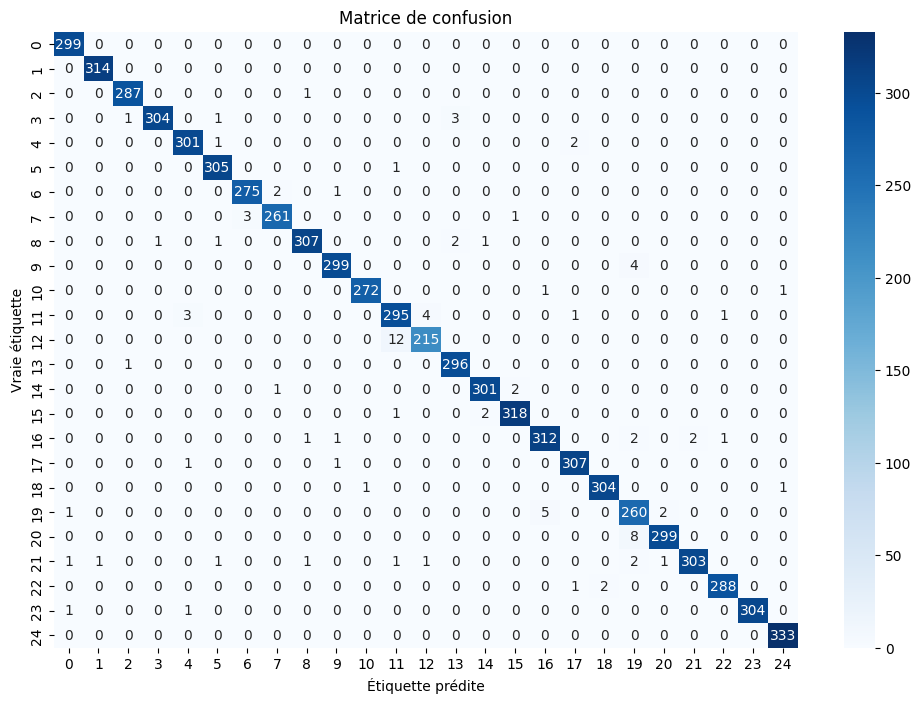

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.title('Matrice de confusion')
plt.show()

In [20]:
joblib.dump(model_xgb, 'model_xgb.pkl')

['model_xgb.pkl']

In [21]:
model = joblib.load('model_xgb.pkl')

In [23]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands.Hands(static_image_mode=False,
                                    max_num_hands=1,
                                    min_detection_confidence=0.5,
                                    min_tracking_confidence=0.5)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = mp_hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
            keypoints = np.array(keypoints).flatten()
            prediction = model.predict([keypoints])
            prediction = class_names[prediction[0]]
            cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    cv2.imshow('Handpose', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@258.687] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@258.687] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
E0000 00:00:1707165308.683322   15296 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707165308.683380   15296 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707165308.683402   15296 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)


In [63]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, n_jobs=4)
# grid_search.fit(X_train, y_train_encoded)

# print("Meilleurs hyperparamètres :")
# print(grid_search.best_params_)

Meilleurs hyperparamètres :
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [64]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

In [72]:
# scores = cross_val_score(best_model, X_train, y_train_encoded, cv=5)

# print(f"Model: {type(best_model).__name__}")
# print(f"Cross-validation scores: {scores}")
# print(f"Mean score: {scores.mean()}")
# print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.98619846 0.9881202  0.9881202  0.98724668 0.9886443 ]
Mean score: 0.9876659678546471
Standard deviation: 0.0008601351240455282


In [32]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)